In [17]:
import torch
import os
import pandas as pd
import numpy as np
from utils.config import config_dataset
from utils.helper import ObjectView
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from utils.utils_gan_wasserstein import Discriminator_wassertein, Generator_linear, plot_GAN_loss, fit_gan_wasserstein, build_gan_scenarios

# Set the torch seed for result reproducibility
torch_seed = 3307
torch.manual_seed(torch_seed)

In [18]:
indices = []
non_null_indexes = list(np.delete(np.asarray([i for i in range(96)]), indices))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.load("../data/london/tensor_small/y_tr.pt", weights_only=True)
X_test = torch.load("../data/london/tensor_small/y_val.pt", weights_only=True)
cond_train = torch.load("../data/london/tensor_small/X_tr.pt", weights_only=True)
cond_test = torch.load("../data/london/tensor_small/X_val.pt", weights_only=True)
print(X_train.shape)
print(X_test.shape)
print(cond_train.shape)
print(cond_test.shape)

X_train, X_val, cond_train, cond_val = train_test_split(X_train, cond_train, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, cond_train.shape, cond_test.shape, X_val.shape, cond_val.shape

y_LS_scaler = StandardScaler()
y_LS_scaler.fit(X_train)
y_LS_scaled = y_LS_scaler.transform(X_train)
y_VS_scaled = y_LS_scaler.transform(X_val)
y_TEST_scaled = y_LS_scaler.transform(X_test)

x_LS_scaler = StandardScaler()
x_LS_scaler.fit(cond_train)
x_LS_scaled = x_LS_scaler.transform(cond_train)
x_VS_scaled = x_LS_scaler.transform(cond_val)
x_TEST_scaled = x_LS_scaler.transform(cond_test)

torch.Size([16696, 48])
torch.Size([4174, 48])
torch.Size([16696, 81])
torch.Size([4174, 81])


In [19]:
X_train

tensor([[0.0025, 0.3686, 0.3549,  ..., 0.0165, 0.0104, 0.0044],
        [0.0190, 0.0193, 0.0158,  ..., 0.0273, 0.0231, 0.0195],
        [0.4925, 0.4680, 0.4168,  ..., 0.2036, 0.0625, 0.0377],
        ...,
        [0.0092, 0.0087, 0.0112,  ..., 0.0185, 0.0083, 0.0090],
        [0.0290, 0.0282, 0.0294,  ..., 0.0285, 0.0291, 0.0283],
        [0.0047, 0.0112, 0.0129,  ..., 0.0319, 0.0267, 0.0300]])

In [20]:
# --------------------------------------------------------------------------------------------------
# Set the model
# --------------------------------------------------------------------------------------------------
# n_s = 100 # num of samples
n_s = 20
N_q = 48
# semble un bon set de hp mais d'un calcul a l'autre les résultats changent bcp ...
nb_epoch = 200
cf_GAN_wasserstein = {
    'name': 'WGANGP_1',
    'cond_in': x_LS_scaled.shape[1],
    'in_size': y_LS_scaled.shape[1],
    'latent_s': 512,
    'gen_w': 256 * 4,
    'gen_l': 2,
    'n_discriminator': 5,
    'lambda_gp': 10,
    'betas': (0.0, 0.9),
    'weight_decay': 1 * 10 ** (-4),
    'learning_rate': 2 * 10 ** (-4),
}

print('WGAN-GP latent_s %s gen_w %s gen_l %s weight_decay %.4e lr %.4e lambda_gp %s' % (cf_GAN_wasserstein['latent_s'], cf_GAN_wasserstein['gen_w'], cf_GAN_wasserstein['gen_l'], cf_GAN_wasserstein['weight_decay'], cf_GAN_wasserstein['learning_rate'], cf_GAN_wasserstein['lambda_gp']))


WGAN-GP latent_s 512 gen_w 1024 gen_l 2 weight_decay 1.0000e-04 lr 2.0000e-04 lambda_gp 10


In [21]:
config = cf_GAN_wasserstein

config['Adam_args'] = {"betas":config['betas'], "lr": config['learning_rate'], "weight_decay": config['weight_decay']}

# Instance critic neural network: discriminator using Wasserstein distance estimate
dis = Discriminator_wassertein(latent_s=config['latent_s'], cond_in=config['cond_in'], in_size=config['in_size'], gen_w=config['gen_w'], gen_l=config['gen_l'], lambda_gp=config['lambda_gp'], gpu=True)
dis.weights_initialize(mean=0.0, std=0.02)
dis.train()
# Instance generator neural network
gen = Generator_linear(latent_s=config['latent_s'], cond_in=config['cond_in'], in_size=config['in_size'], gen_w=config['gen_w'], gen_l=config['gen_l'], gpu=True)
gen.weights_initialize(mean=0.0, std=0.02)
gen.train()

# Instance optimizers
opt_D = torch.optim.Adam(dis.parameters(), lr=config['learning_rate'], betas=config['betas'], weight_decay=config['weight_decay'])
opt_G = torch.optim.Adam(gen.parameters(), lr=config['learning_rate'], betas=config['betas'], weight_decay=config['weight_decay'])

# -----------------------------------------------------------------------------------------------
# Fit the GAN
# -----------------------------------------------------------------------------------------------
print('Fit GAN with %s epochs' % (nb_epoch))
training_time = 0.
loss, gen, dis = fit_gan_wasserstein(nb_epoch=nb_epoch, x_LS=x_LS_scaled, y_LS=y_LS_scaled, x_VS=x_VS_scaled,
                                                y_VS=y_VS_scaled, x_TEST=x_TEST_scaled, y_TEST=y_TEST_scaled, gen=gen, dis=dis, opt_gen=opt_G, opt_dis=opt_D, n_discriminator=config['n_discriminator'], gpu=True)

print('Training time %.2f s' % (training_time))
epoch_min_D = np.nanargmin(loss[:, 2])
epoch_min_G = np.nanargmin(loss[:, 3])
print('epoch %s loss D VS is min = %.2f epoch %s loss G VS is min = %.2f' % (epoch_min_D, loss[epoch_min_D, 2], epoch_min_G, loss[epoch_min_G, 3]))

Fit GAN with 200 epochs
Fitting time_tot 0 mintime left : 0.013003 min - D LS loss: -1.913018 G LS loss: -6.566139 D VS loss: -1.142193 G VS loss: -7.139888
Training time 0.00 s
epoch 25 loss D VS is min = -4.59 epoch 157 loss G VS is min = -7.44


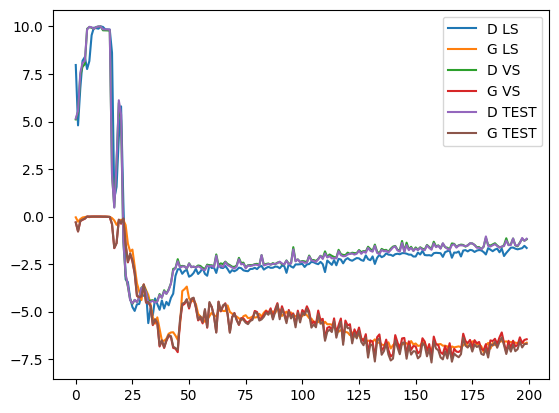

In [22]:
plt.figure()
plt.plot(loss[:, 0], label='D LS')
plt.plot(loss[:, 1], label='G LS')
plt.plot(loss[:, 2], label='D VS')
plt.plot(loss[:, 3], label='G VS')
plt.plot(loss[:, 4], label='D TEST')
plt.plot(loss[:, 5], label='G TEST')
plt.legend()

In [23]:
max_cap = 20
tag = "load"
# Scenarios are generated into a dict of length nb days (#VS or # TEST sizes)
# Each day of the dict is an array of shape (n_scenarios, 24)
generation_time = 0.
# s_LS = build_gan_scenarios(n_s=n_s, x=x_LS_scaled, y_scaler=y_LS_scaler, gen=gen, max=max_cap, gpu=gpu, tag=tag, non_null_indexes=non_null_indexes)
s_TEST = build_gan_scenarios(n_s=n_s, x=x_TEST_scaled, y_scaler=y_LS_scaler, gen=gen, max=max_cap, gpu=True, tag=tag, non_null_indexes=non_null_indexes)
s_train = build_gan_scenarios(n_s=n_s, x=x_LS_scaled, y_scaler=y_LS_scaler, gen=gen, max=max_cap, gpu=True, tag=tag, non_null_indexes=non_null_indexes)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
X_test_hat = s_TEST.reshape(-1, 48, s_TEST.shape[-1])
X_test_hat = torch.tensor(X_test_hat).permute(0, 2, 1)

In [25]:
X_train_hat = s_train.reshape(-1, 48, s_train.shape[-1])
X_train_hat = torch.tensor(X_train_hat).permute(0, 2, 1)

In [26]:
X_test_hat.shape, X_train_hat.shape

(torch.Size([4174, 20, 48]), torch.Size([15026, 20, 48]))

In [27]:
torch.save(X_test_hat, "../result/data/london/load_hat_gan.pt")

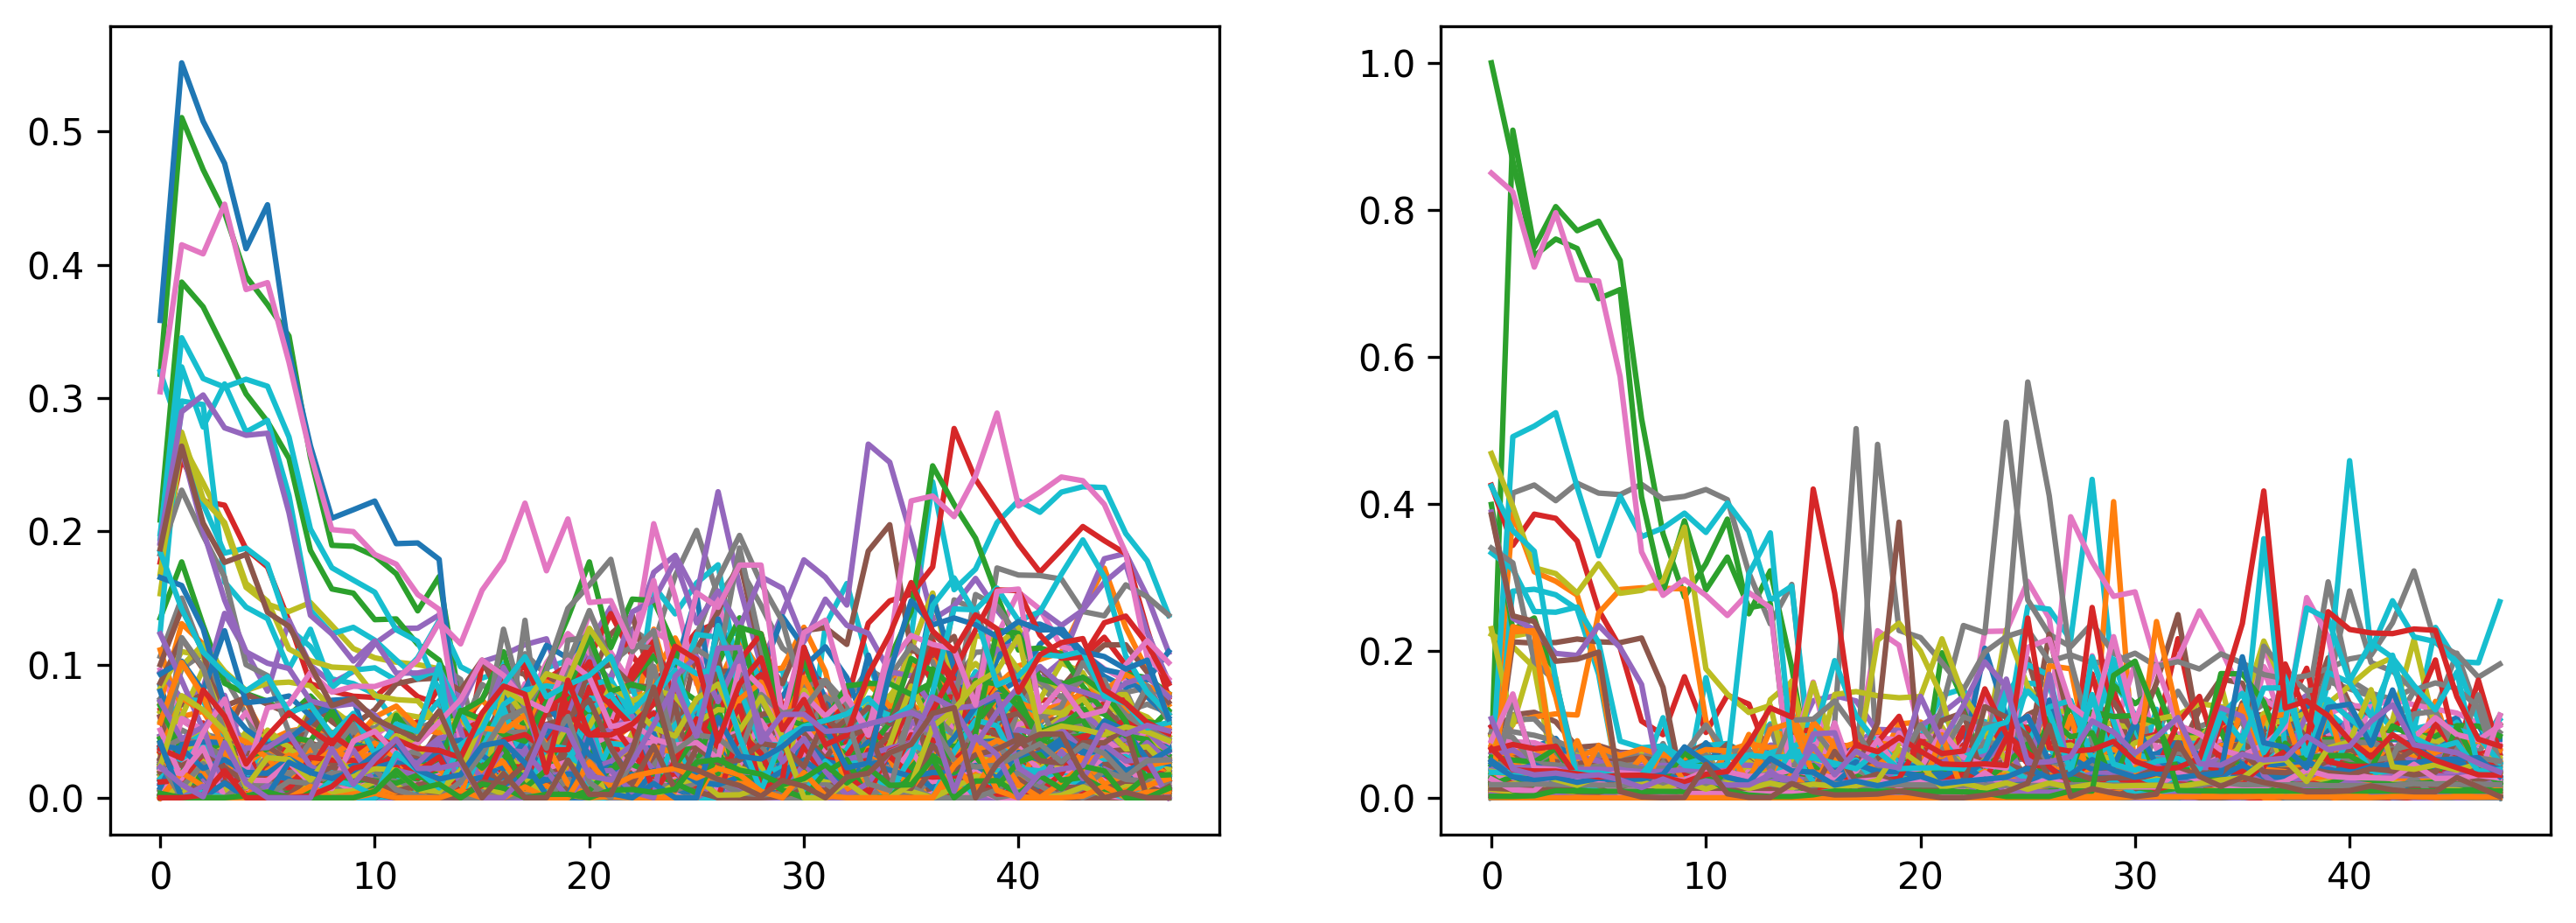

In [28]:
user = 0
plt.figure(figsize=(12,4), dpi=300)
plt.subplot(1,2,1)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test_hat[i, 0, :])
plt.subplot(1,2,2)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test[i])

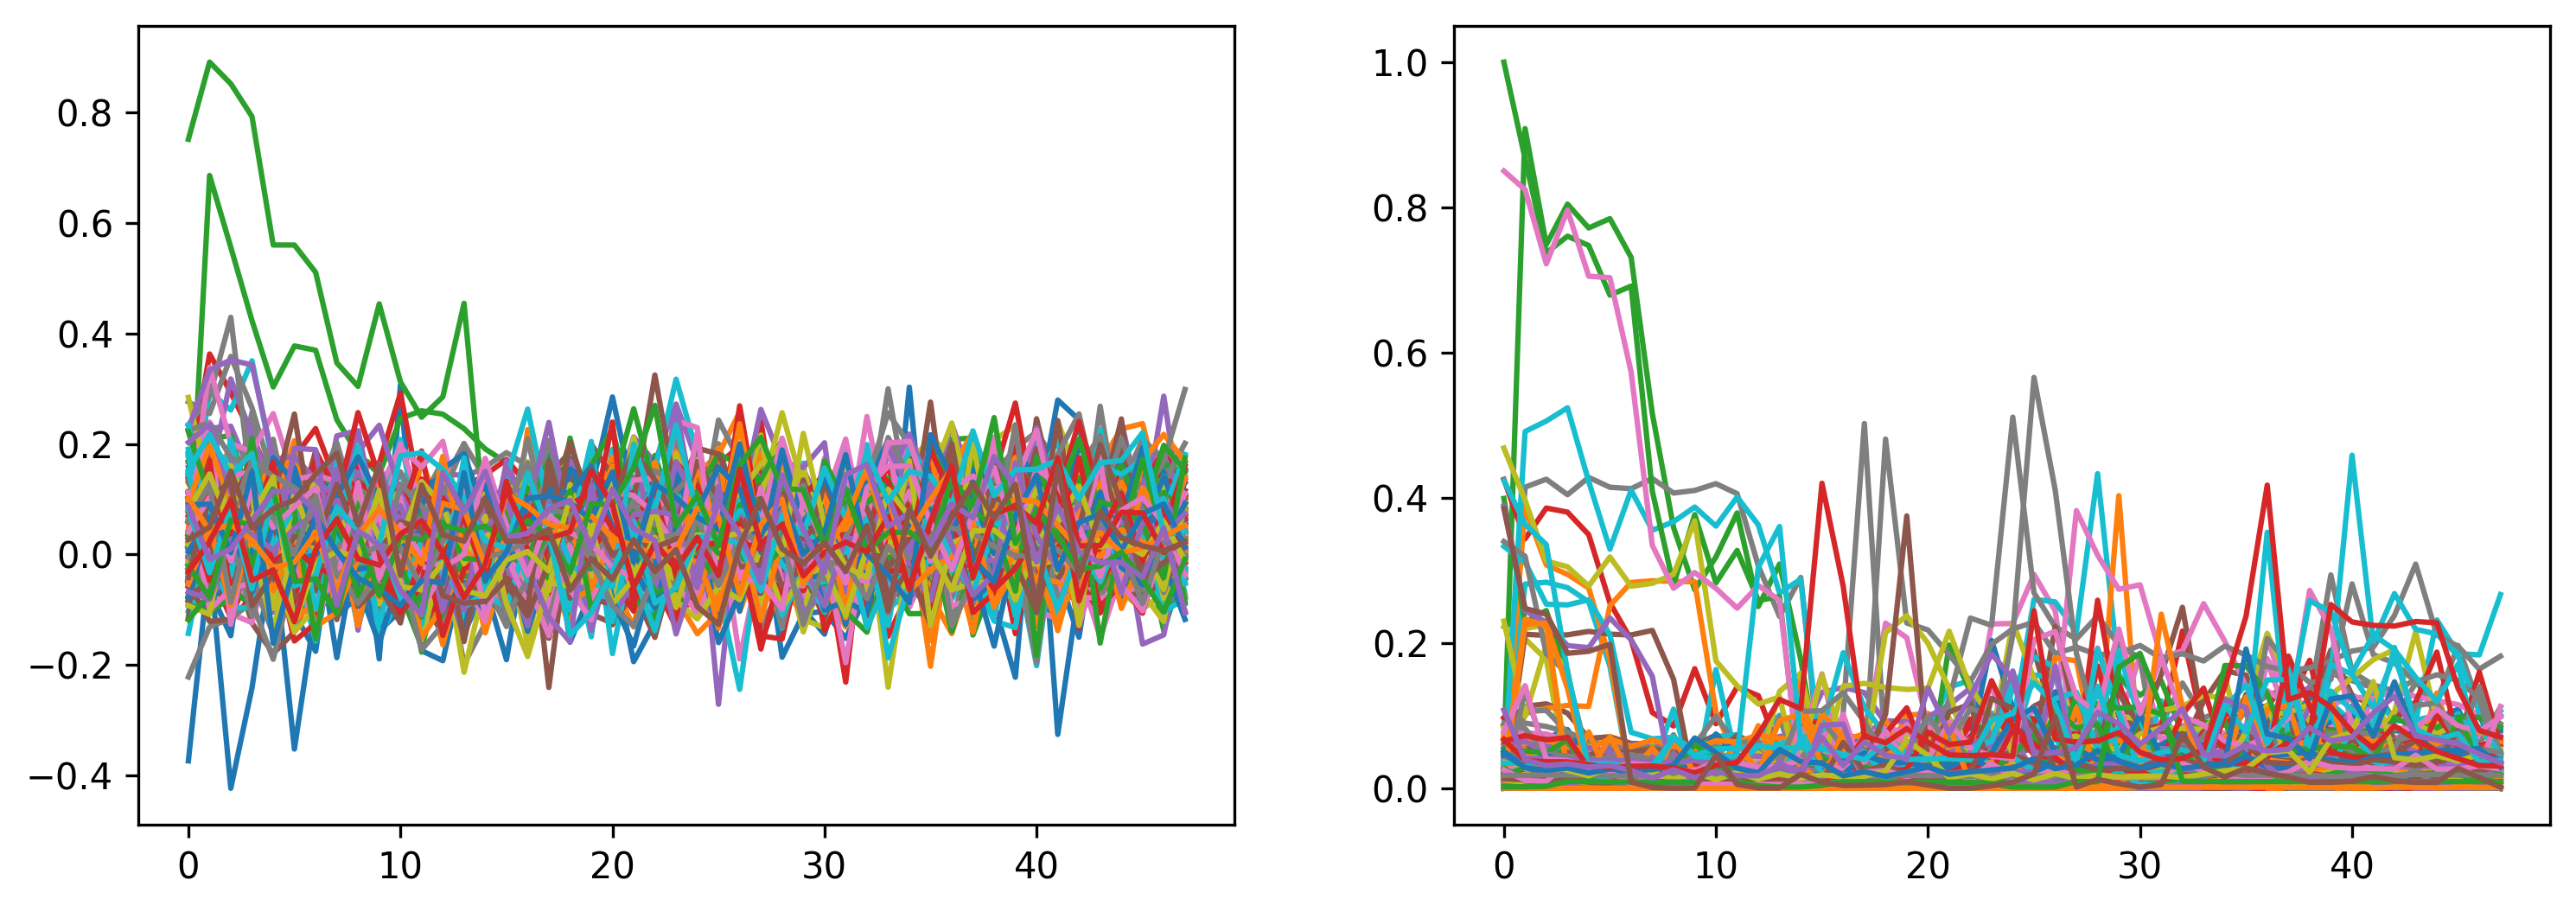

In [29]:
# X_test_hat_diff = torch.load("../result/data/london/load_hat_diff_base.pt", weights_only=True)
# user = 0
# plt.figure(figsize=(12,4), dpi=300)
# plt.subplot(1,2,1)
# for i in range(146*user, 146*(user+1)):
#     plt.plot(X_test_hat_diff[i, 0, :])
# plt.subplot(1,2,2)
# for i in range(146*user, 146*(user+1)):
#     plt.plot(X_test[i])

In [30]:
# n = 20
# plt.figure(figsize=(20,20), dpi=300)
# for j in range(n):
#     plt.subplot(int(n/4), 4, j+1)
#     j = j + 200
#     for i in range(10):
#         plt.plot(X_test_hat[j][i], color='gray')
#     plt.plot(X_test[j])